<a href="https://colab.research.google.com/github/wajidminhas/AI-Agents/blob/main/router_chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We built a graph that uses messages as state and a chat model with bound tools.

  We saw that the graph can:

  Return a tool call
  Return a natural language response

#Goals

  We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

  This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

SECRET ADDED AND ACCESS API KEY

In [2]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

#here we will create a tool/function

def multiply(a: int, b: int) -> int:


  """
  Multiply two numbers

  """
  return a * b

llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash", api_key=GEMINI_API_KEY)
llm_with_tools = llm.bind_tools([multiply])

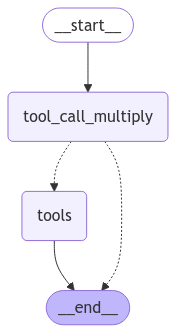

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.state import CompiledStateGraph


#here we create node
def tool_call_multiply(state: MessagesState):
  return {"messages" : [llm_with_tools.invoke(state["messages"])]}

# BUILD GRAPH

builder:StateGraph = StateGraph(MessagesState)
builder.add_node("tool_call_multiply" , tool_call_multiply)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_call_multiply")

builder.add_conditional_edges("tool_call_multiply", tools_condition)

builder.add_edge("tools", END)

graph : CompiledStateGraph = builder.compile()


#view / display
display(Image(graph.get_graph().draw_mermaid_png()))






In [12]:
from langchain_core.messages import HumanMessage, SystemMessage
messages = [SystemMessage(content="") , HumanMessage(content="What is multiply of 2 and 3")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


================================ Human Message =================================

What is multiply of 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (436e7f21-8519-4727-b54a-0f9c375292f6)
 Call ID: 436e7f21-8519-4727-b54a-0f9c375292f6
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
